#Dataset:
https://www.kaggle.com/plameneduardo/sarscov2-ctscan-dataset

In [ ]:
!nvidia-smi

Sun Jan 23 14:30:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocessing Data

In [ ]:
import shutil
import os
import numpy as np

def get_files_from_folder(path):

    files = os.listdir(path)
    return np.asarray(files)

def main(path_to_data, path_to_test_data, train_ratio):
    # get dirs
    _, dirs, _ = next(os.walk(path_to_data))

    # calculates how many train data per class
    data_counter_per_class = np.zeros((len(dirs)))
    for i in range(len(dirs)):
        path = os.path.join(path_to_data, dirs[i])
        files = get_files_from_folder(path)
        data_counter_per_class[i] = len(files)
    test_counter = np.round(data_counter_per_class * (1 - train_ratio))

    # transfers files
    for i in range(len(dirs)):
        path_to_original = os.path.join(path_to_data, dirs[i])
        path_to_save = os.path.join(path_to_test_data, dirs[i])

        #creates dir
        if not os.path.exists(path_to_save):
            os.makedirs(path_to_save)
        files = get_files_from_folder(path_to_original)
        # moves data
        for j in range(int(test_counter[i])):
            dst = os.path.join(path_to_save, files[j])
            src = os.path.join(path_to_original, files[j])
            shutil.move(src, dst)


if __name__ == "__main__":
  main("/content/train2", "/content/test2", float(0.8))

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

In [ ]:
!unzip *.zip && rm -rf *.zip

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
  rotation_range=40,
  rescale=1./255,
  horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    "/content/train2",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    "/content/test2",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical"
)

Found 1985 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


#Model

In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet',
              include_top=False,
              input_shape = (224, 224, 3))

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
def layer_adder(bottom_model, numclasses):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(numclasses, activation='softmax')(top_model)
  return top_model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Input
from keras.models import Model


FC_Head = layer_adder(model, 2)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("vgg_covid_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [ ]:
history = model.fit(train_generator,
                    epochs = 100,
                    callbacks=callbacks,
                    validation_data=test_generator)

Epoch 1/100
125/125 [==============================] - ETA: 0s - loss: 0.5105 - accuracy: 0.7446
Epoch 00001: val_loss improved from inf to 0.42927, saving model to vgg_covid_model.h5
125/125 [==============================] - 39s 263ms/step - loss: 0.5105 - accuracy: 0.7446 - val_loss: 0.4293 - val_accuracy: 0.8085
Epoch 2/100
124/125 [============================>.] - ETA: 0s - loss: 0.4439 - accuracy: 0.7989
Epoch 00002: val_loss improved from 0.42927 to 0.40704, saving model to vgg_covid_model.h5
125/125 [==============================] - 33s 262ms/step - loss: 0.4443 - accuracy: 0.7985 - val_loss: 0.4070 - val_accuracy: 0.8085
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 0.3999 - accuracy: 0.8317
Epoch 00003: val_loss improved from 0.40704 to 0.35645, saving model to vgg_covid_model.h5
125/125 [==============================] - 32s 258ms/step - loss: 0.3999 - accuracy: 0.8317 - val_loss: 0.3565 - val_accuracy: 0.8468
Epoch 4/100
125/125 [=================

In [ ]:
model.evaluate(test_generator)

31/31 [==============================] - 3s 88ms/step - loss: 0.2862 - accuracy: 0.8851


[0.2862018048763275, 0.8850806355476379]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!cp "/content/vgg_covid_model.h5" "/content/drive/MyDrive"

In [ ]:
def predictCT(image):
  import tensorflow as tf
  img = tf.keras.preprocessing.image.load_img(
      image, target_size=(224, 224)
  )
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  return np.argmax(predictions)

In [ ]:
predictCT("/content/test/CT_NonCOVID/1336.png")

1

In [ ]:
import os

covid_images = [os.path.join("/content/test2/COVID", img) for img in os.listdir("/content/test2/COVID")]
noncovid_images = [os.path.join("/content/test2/non-COVID", img) for img in os.listdir("/content/test2/non-COVID")]

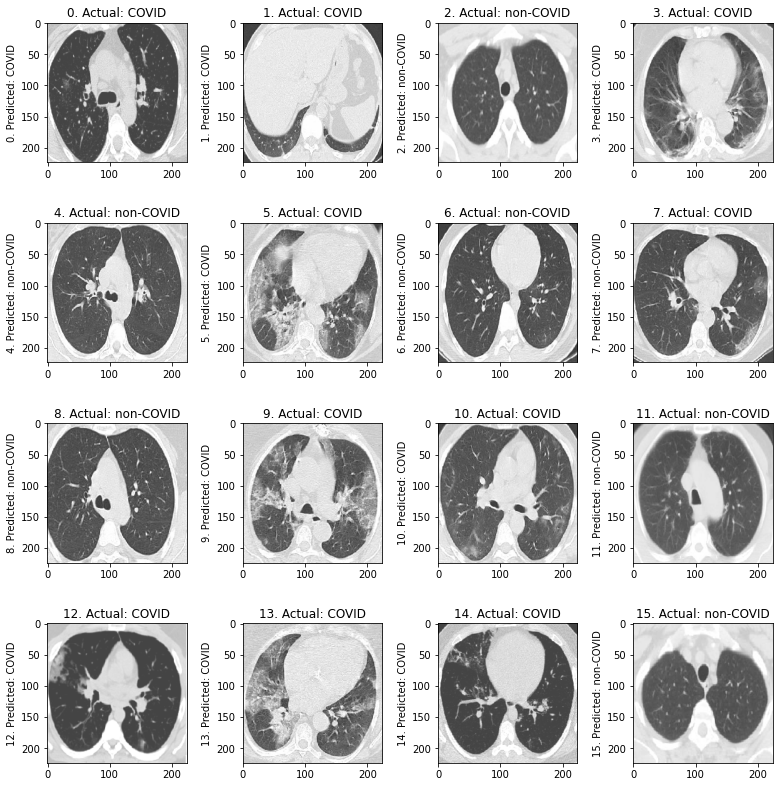

In [ ]:
images, labels = test_generator.__next__()
labels_names = ['COVID', 'non-COVID']
plt.figure(figsize=(13,13))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(images[i])
  plt.title("{}. Actual: {}".format(i, labels_names[np.argmax(labels[i])]))
  prediction = model.predict(np.reshape(images[i], (-1, 224, 224, 3)))
  plt.ylabel(f"{i}. Predicted: {labels_names[np.argmax(prediction)]}")
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.35)
plt.show()

In [ ]:
train_generator.class_indices

{'COVID': 0, 'non-COVID': 1}